# Calibration of spectra
`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 28 Aug 2022

Adapted from HAP703P

References: *Handbook of CCD Astronomy* §6 ; *Handbook of Astronomical Spectroscopy* §6
* flat field correction of stellar and calibration spectra
* wavelength calibration of stellar spectra
* save spectra as FITS files

In [1]:
# import and settings
%matplotlib notebook
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import astropy.io.fits as pf
from astropy.modeling import models
from astropy.stats import mad_std
from astropy.table import QTable
from astropy import units as u
import pydis_um 
from astroplan.plots import plot_finder_image
from astroplan import FixedTarget
from astropy.visualization import ZScaleInterval
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from astroplan import FixedTarget, Observer
from astropy.nddata import StdDevUncertainty
from pytz import timezone
import ccdproc as ccdp
from specutils.manipulation import LinearInterpolatedResampler
import specutils
import specutils.fitting as spf
from specutils.manipulation import extract_region
from specutils import Spectrum1D, SpectralRegion
from iraf_um import imstat

C:\Users\adria\OneDrive\Bureau\Faculté\M2\ohp\V10 Adrian\21-09-22\pydis_um.py:140: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if Saxis is 0:
C:\Users\adria\OneDrive\Bureau\Faculté\M2\ohp\V10 Adrian\21-09-22\pydis_um.py:167: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if Saxis is 1:
C:\Users\adria\OneDrive\Bureau\Faculté\M2\ohp\V10 Adrian\21-09-22\pydis_um.py:214: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if Saxis is 1:
C:\Users\adria\OneDrive\Bureau\Faculté\M2\ohp\V10 Adrian\21-09-22\pydis_um.py:251: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if Saxis is 1:


## Load previously computed data 

In [2]:
# define CCD characteristics
ccd_gain = 0.9709756374359131 * u.electron / u.adu
ccd_ron = 2.8359016154485057 * u.electron

In [3]:
# define file names
fname_sci = 'Master_M76_s1d.fit'
fname_rvstd = 'Master_ksi_Cas_s1d.fit'
# load spectra
sci_s1d = ccdp.CCDData.read('reduced/' + fname_sci)
rvstd_s1d = ccdp.CCDData.read('reduced/' + fname_rvstd)
mflat_s1d = ccdp.CCDData.read('reference/master_flat_s1d.fits')
mwcal_s1d = ccdp.CCDData.read('reference/master_wcal_s1d.fits')

## Normalise flat field and correct other frames

Fit RMS deviation = 0.184 e-


<IPython.core.display.Javascript object>


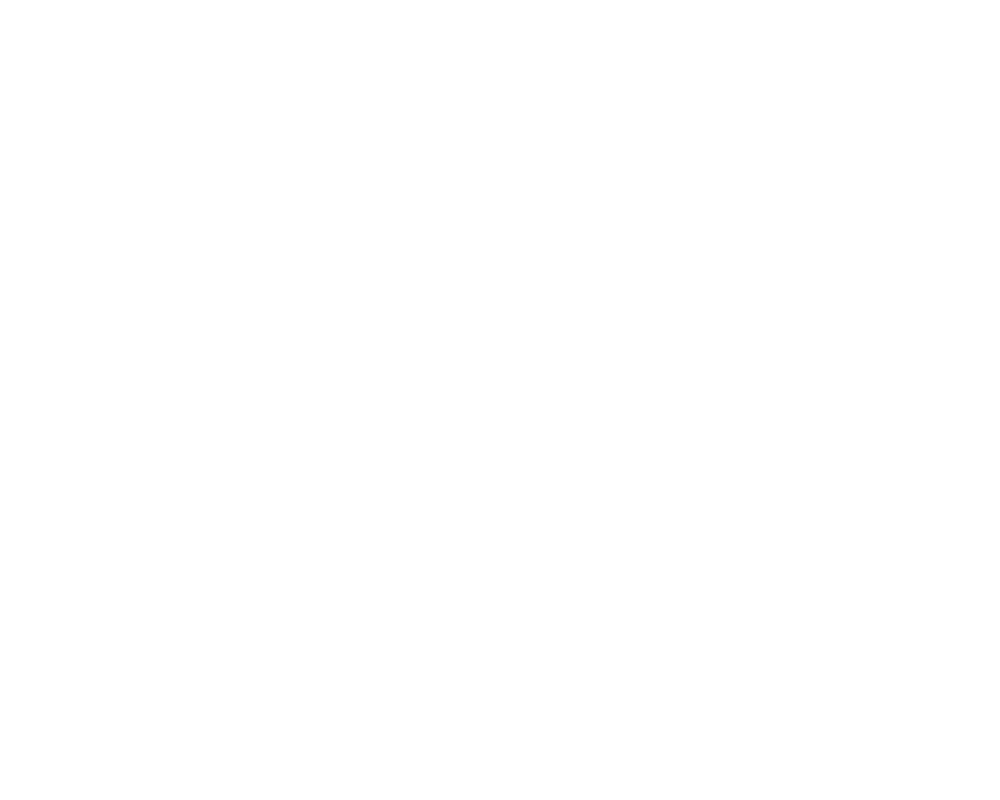

In [4]:
# normalise flat field to keep only small-scale variations
mflat_s1d_medfilt = sp.ndimage.median_filter(mflat_s1d.data, size=100)
x_ccd = np.linspace(0, mflat_s1d.data.shape[0],  mflat_s1d.data.shape[0])
mflat_coeff = np.polyfit(x_ccd, mflat_s1d.data, deg=4) #### MODIF Deg =3 -> Deg =4
mflat_fit = np.poly1d(mflat_coeff)(x_ccd)
mflat_n_s1d = mflat_s1d.data / mflat_fit
#
rms = np.sqrt(np.mean((mflat_fit - mflat_s1d.data)**2))
print("Fit RMS deviation = %.3f e-" % rms)

# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(mflat_s1d.data, c='tab:blue')
ax1.plot(mflat_fit, c='tab:orange')
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.set_title('Master flat field and polynomial fit')
#
ax2 = fig.add_subplot(212)
ax2.plot(mflat_n_s1d, c='tab:green')
ax2.axvline(850, ls='--', c='k', lw=0.4)
ax2.set_title('normalised master flat field')
#
plt.show()

<IPython.core.display.Javascript object>


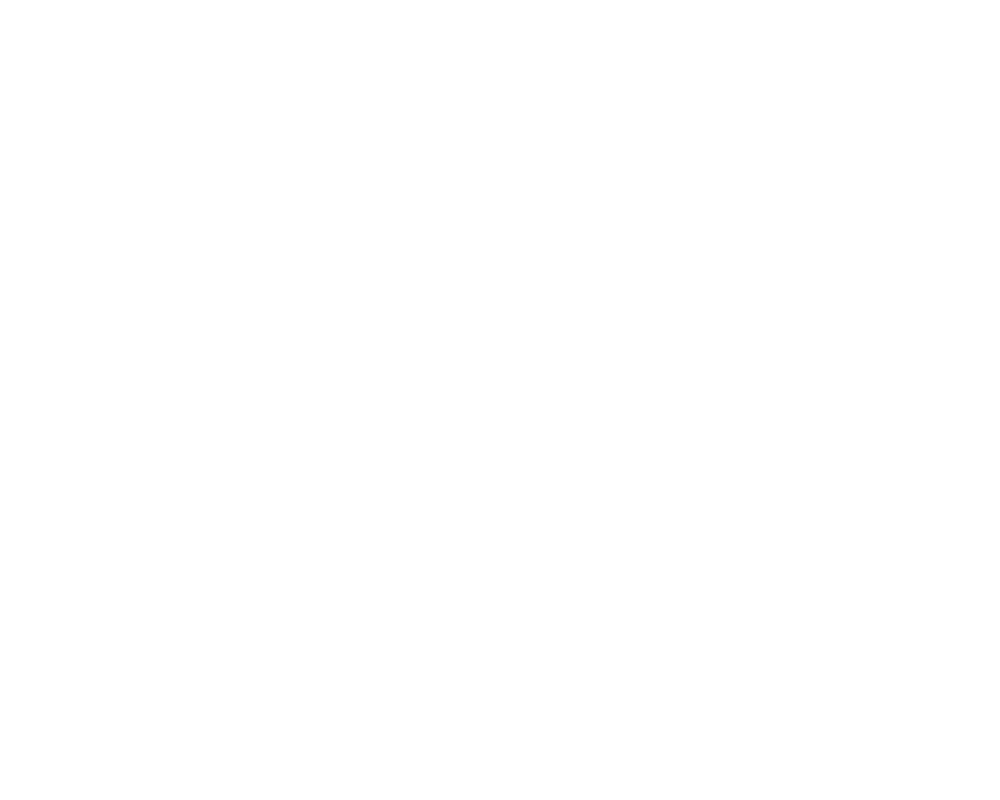

In [5]:
# apply flat field correction to science and rv std spectra
sci_f_s1d = sci_s1d.data / mflat_n_s1d
sig_sci_f_s1d = copy.deepcopy(sci_s1d.uncertainty)
#sig_sci_f_s1d /= mflat_n_s1d
#
rvstd_f_s1d = rvstd_s1d.data / mflat_n_s1d
sig_rvstd_f_s1d = copy.deepcopy(rvstd_s1d.uncertainty)
#sig_rvstd_f_s1d /= mflat_n_s1d


# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(sci_s1d.data, c='tab:blue')
ax1.plot(sci_f_s1d, c='tab:orange')
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.set_title('Science spectrum before and after flat field correction')
#
ax2 = fig.add_subplot(212)
ax2.plot(rvstd_s1d.data, c='tab:blue')
ax2.plot(rvstd_f_s1d, c='tab:orange')
ax2.axvline(850, ls='--', c='k', lw=0.4)
ax2.set_title('RV Standard spectrum before and after flat field correction')
#
plt.show()

1975.0209398547559


<IPython.core.display.Javascript object>


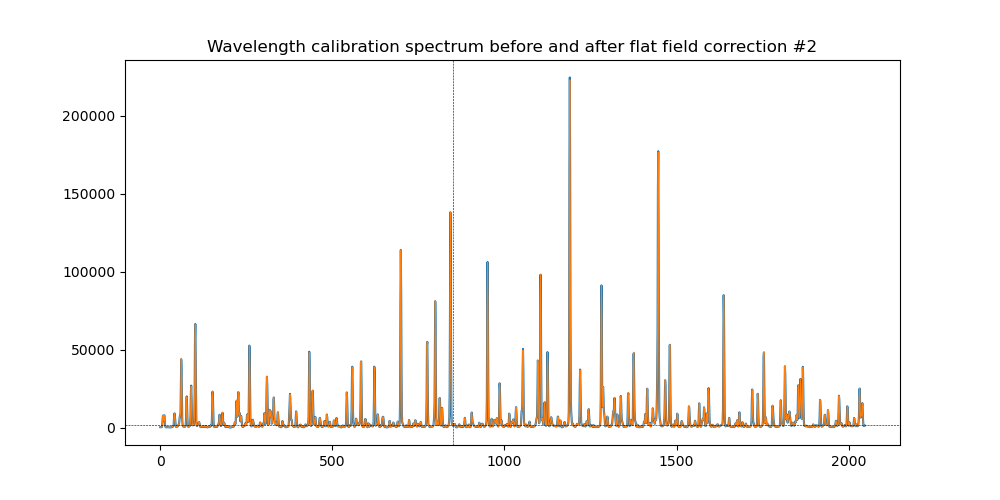

In [6]:
# apply flat field correction to wavelength calibration spectrum
## flat field normalised by polynomial fit
mwcal_f_s1d = mwcal_s1d.data / mflat_n_s1d
# compute baseline level
mwcal_base = np.median(mwcal_f_s1d[1100:])
print(mwcal_base)
# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
#
ax1 = fig.add_subplot(111)
ax1.plot(mwcal_s1d.data, c='tab:blue')
ax1.plot(mwcal_f_s1d, c='tab:orange', lw=.8)
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.axhline(mwcal_base, ls='--', c='k', lw=0.4)
ax1.set_title('Wavelength calibration spectrum before and after flat field correction #2')
#
plt.show()
# remove baseline level from wcal frame
mwcal_f_s1d -= mwcal_base

## Wavelength calibration

In [7]:
# convert wcal spectrum to a specutils.Spectrum1D instance
mwcal_f_s1d = specutils.Spectrum1D(mwcal_f_s1d.data*u.adu)

29 emission lines identified
line_center line_type line_center_index
    pix                                
----------- --------- -----------------
       61.0  emission                61
      101.0  emission               101
      259.0  emission               259
      310.0  emission               310
      433.0  emission               433
      557.0  emission               557
      583.0  emission               583
      622.0  emission               622
      699.0  emission               699
      775.0  emission               775
        ...       ...               ...
     1281.0  emission              1281
     1375.0  emission              1375
     1446.0  emission              1446
     1467.0  emission              1467
     1480.0  emission              1480
     1637.0  emission              1637
     1753.0  emission              1753
     1815.0  emission              1815
     1860.0  emission              1860
     1867.0  emission              1867
Length = 29

<IPython.core.display.Javascript object>


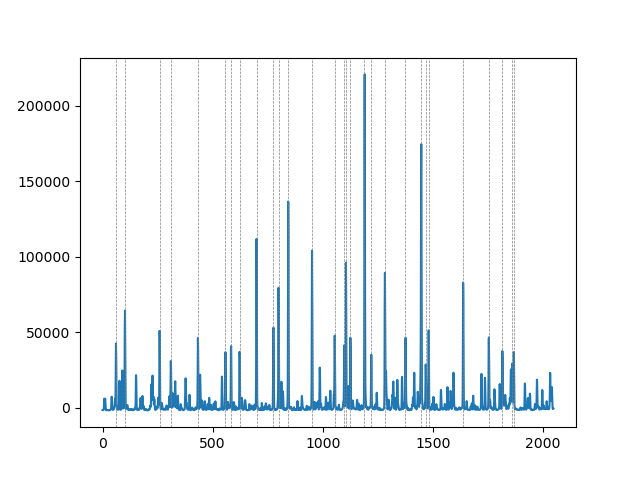

In [8]:
# detect spectral lines
#lines = spf.find_lines_derivative(mwcal_f_s1d, flux_threshold=1.e5)
lines = spf.find_lines_derivative(mwcal_f_s1d, flux_threshold=2.7e4)
lines[lines['line_type'] == 'emission']
print("%d emission lines identified" % len(lines))
print(lines)
# plot identified lines
plt.figure()
plt.plot(mwcal_f_s1d.flux)
for l in lines:
    plt.axvline(l['line_center_index'], ls='--', c='grey', lw=0.5)
plt.show()

<IPython.core.display.Javascript object>


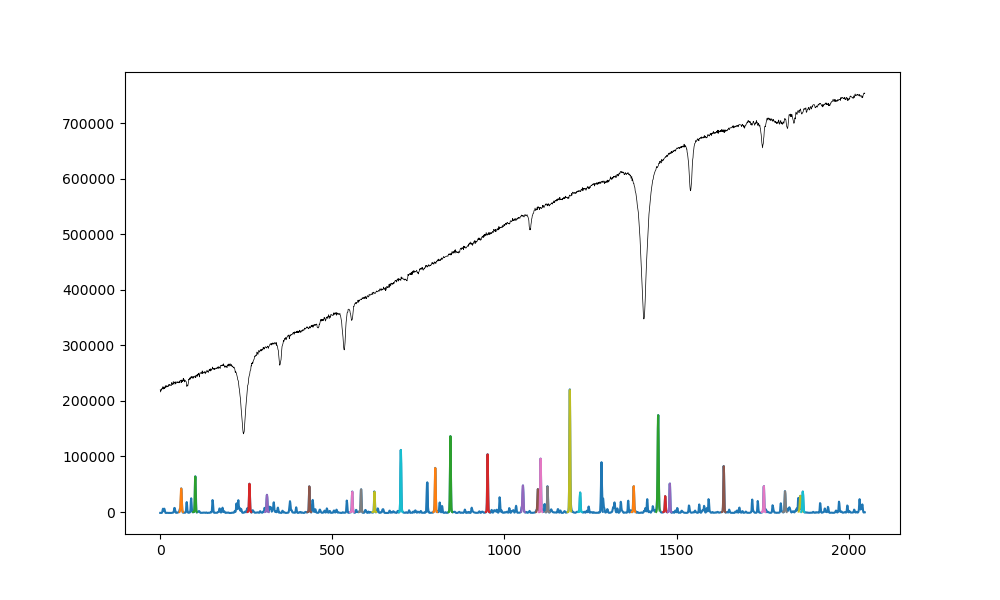

In [9]:
# fit each line w/ a gaussian model to retrieve the central pixel and fwhm
## overplot the RV std spectrum for reference
wcal_amp = []
wcal_x = []
wcal_std = []
plt.figure(figsize=(10,6))
plt.plot(rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(mwcal_f_s1d.flux)
for l in lines:
    sub_region = SpectralRegion((l['line_center_index']-4)*u.pix, (l['line_center_index']+4)*u.pix)
    sub_spectrum = extract_region(mwcal_f_s1d, sub_region)
    g = spf.estimate_line_parameters(sub_spectrum, models.Gaussian1D())
    wcal_amp.append(g.amplitude.value)
    wcal_x.append(g.mean.value)
    wcal_std.append(g.stddev.value)
    xx = np.linspace((l['line_center_index']-5)*u.pix,(l['line_center_index']+5)*u.pix,22)
    plt.plot(xx, g(xx))
plt.show()

In [10]:
# associate two observed lines to tabulated ThAr lines and compute preliminary solution
wcal_lam = -1. * np.ones_like(wcal_x)
wcal_lam[7] = 4391.11 # Ar
wcal_lam[17] = 4609.55 # Ar
# linear solution lam = a*x + b
a = (wcal_lam[7] - wcal_lam[17]) / (wcal_x[7] - wcal_x[17])
b = wcal_lam[17] - a*wcal_x[17]
print('a = ', a*u.AA, ' ; b = ', b*u.AA)
lam0 = a*mwcal_f_s1d.spectral_axis.value + b

a =  0.3848913079418799 Angstrom  ; b =  4151.502550054772 Angstrom


<IPython.core.display.Javascript object>


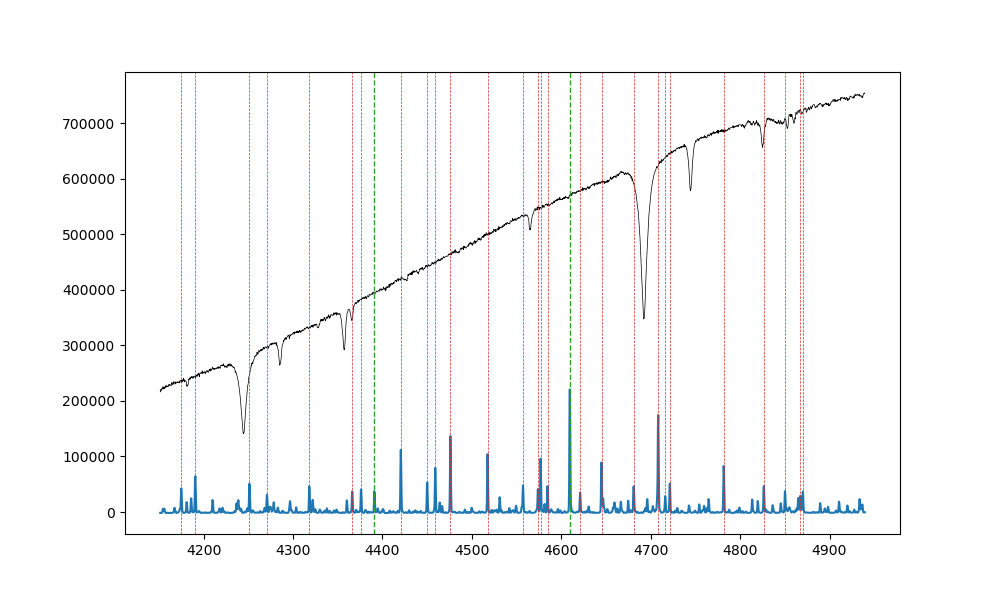

In [11]:
# Re-plot spectrum w/ this first solution and identify other lines
plt.figure(figsize=(10,6))
plt.plot(lam0, rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(lam0, mwcal_f_s1d.flux)
for i, x in enumerate(wcal_x):
    if wcal_lam[i] > 1.:
        plt.axvline(a*x+b, ls='--', c='tab:green', lw=1.)
    elif wcal_lam[i] < 0.:
        plt.axvline(a*x+b, ls='--', c='tab:red', lw=0.5)
    else:
        plt.axvline(a*x+b, ls='--', c='grey', lw=0.5)

plt.show()

In [12]:
# identify more lines
# iterate from here until all useful lines are identified
wcal_lam = -1. * np.ones_like(wcal_x)
print(np.shape(wcal_lam))
wcal_lam[0] = 4259.36
#wcal_lam[1] =
#wcal_lam[2] = 4272.17
#wcal_lam[3] = 4289.04 #?
#wcal_lam[4] = 4300.10
#wcal_lam[5] = 4312.99
wcal_lam[2] = 4348.06
#wcal_lam[3] = 4370.75
#wcal_lam[8] = 4391.11
wcal_lam[4] = 4426.01
#wcal_lam[10] =
#wcal_lam[11] = 4474.77
#wcal_lam[12] = 
wcal_lam[6] = 4493.33
wcal_lam[7] = 4510.74
wcal_lam[8] = 4545.05
wcal_lam[9] = 4579.35
wcal_lam[10] = 4589.90
#wcal_lam[18] =
wcal_lam[11] = 4609.55
wcal_lam[12] = 4657.94
#wcal_lam[21] = 4673.66
#wcal_lam[13] = 4703.99
#wcal_lam[14] = 
wcal_lam[15] = 4726.86
wcal_lam[16] = 4735.91
#wcal_lam[17] = 
wcal_lam[18] = 4778.30
wcal_lam[19] = 4806.02
#wcal_lam[29] =
#wcal_lam[30] =
#wcal_lam[31] =
#wcal_lam[20] = 4847.82
#wcal_lam[33] = 4865.48
#wcal_lam[21] = 4879.88
#wcal_lam[22] = 
wcal_lam[23] = 4894.96
#wcal_lam[37] = 4945.47
wcal_lam[24] = 4965.07
#wcal_lam[39] = 5002.10
#wcal_lam[40] = 
wcal_lam[25] = 5017.26
#wcal_lam[26] = 5044.73
#wcal_lam[43] =
#wcal_lam[27] = 
wcal_lam[28] = 5067.97
#wcal_lam[46] = 
#wcal_lam[47] = 5141.79

(29,)


[60.991629526854524, 259.2766961907535, 433.3247678329317, 583.5987758486012, 622.532764448423, 699.1787183565968, 775.7322462225668, 799.1261808186057, 843.1788103972705, 951.142575597457, 1105.2351478809178, 1125.4016895372918, 1220.088089527784, 1282.1262422802124, 1480.586558330908, 1637.3553778129676, 1753.7812667843637, 1866.9357078847206] [4259.36, 4348.06, 4426.01, 4493.33, 4510.74, 4545.05, 4579.35, 4589.9, 4609.55, 4657.94, 4726.86, 4735.91, 4778.3, 4806.02, 4894.96, 4965.07, 5017.26, 5067.97]


<IPython.core.display.Javascript object>


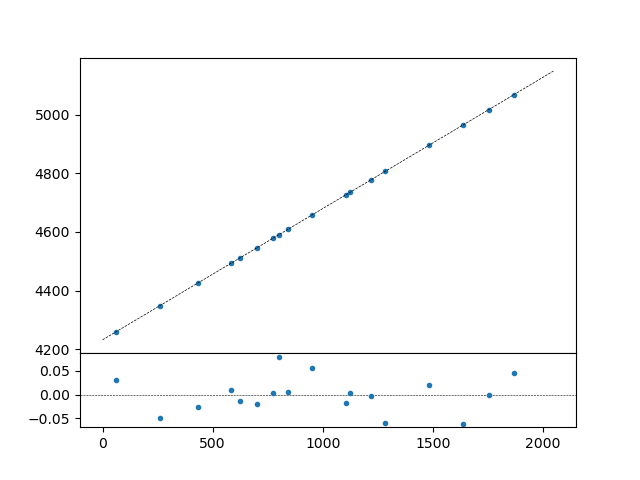

RMS = 0.0367 pix (nlines=18/ndf=15)


In [13]:
# create lists w/ only lines to fit
x_fit = [x for x,l in zip(wcal_x, wcal_lam) if l > 1.]
lam_fit = [l for l in wcal_lam if l > 1.]
print(x_fit, lam_fit)
# polynomial fit for wavelength solution
deg_wcal = 2 # set degree of wavelength calibration polynomial
wcal_coeff = np.polyfit(x_fit, lam_fit, deg=deg_wcal)
lam1 = np.poly1d(wcal_coeff)(mwcal_f_s1d.spectral_axis.value)
# plot fit and residual
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)
# main plot
ax1.plot(x_fit, lam_fit, marker='o', ms=3., color='tab:blue', ls='')
ax1.plot(mwcal_f_s1d.spectral_axis.value, lam1, c='k', ls='--', lw=0.5)
# residual 'O-C'
res = lam_fit - np.poly1d(wcal_coeff)(x_fit)
ax2.axhline(0., ls='--', c='k', lw=0.4)
ax2.plot(x_fit, res, 'o', c='tab:blue', ms=3.)
#ax2.set_xlim(0,1.e3)
#plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()
# Compute and print RMS
rms = np.sqrt(np.mean(res**2))
print("RMS = %.4f pix (nlines=%d/ndf=%d)" % (rms, len(x_fit), len(x_fit)-(deg_wcal+1)))

<IPython.core.display.Javascript object>


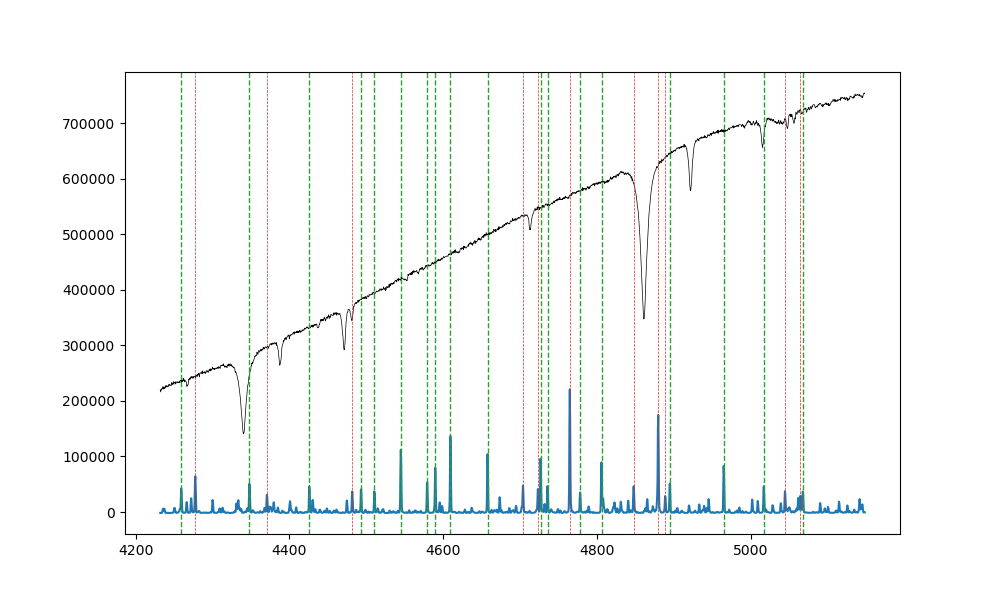

In [14]:
# Re-plot spectrum w/ this first solution and identify other lines
plt.figure(figsize=(10,6))
plt.plot(lam1, rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(lam1, mwcal_f_s1d.flux)
for i, x in enumerate(wcal_x):
    if wcal_lam[i] > 1.:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='tab:green', lw=1.)
    elif wcal_lam[i] < 0.:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='tab:red', lw=0.5)
    else:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='grey', lw=0.5)
#plt.xlim(3500., 8000.)
plt.show()

In [16]:
#Estimation résolution

R_list = [np.poly1d(wcal_coeff)(wcal_x[i])/(2*(np.poly1d(wcal_coeff)(wcal_std[i])-wcal_coeff[2])) for i in range(len(wcal_x))]
print(np.cumsum(R_list)[len(R_list)-1]/len(R_list))

4220.840206749662


## Apply redshift + combine spectrums

<IPython.core.display.Javascript object>


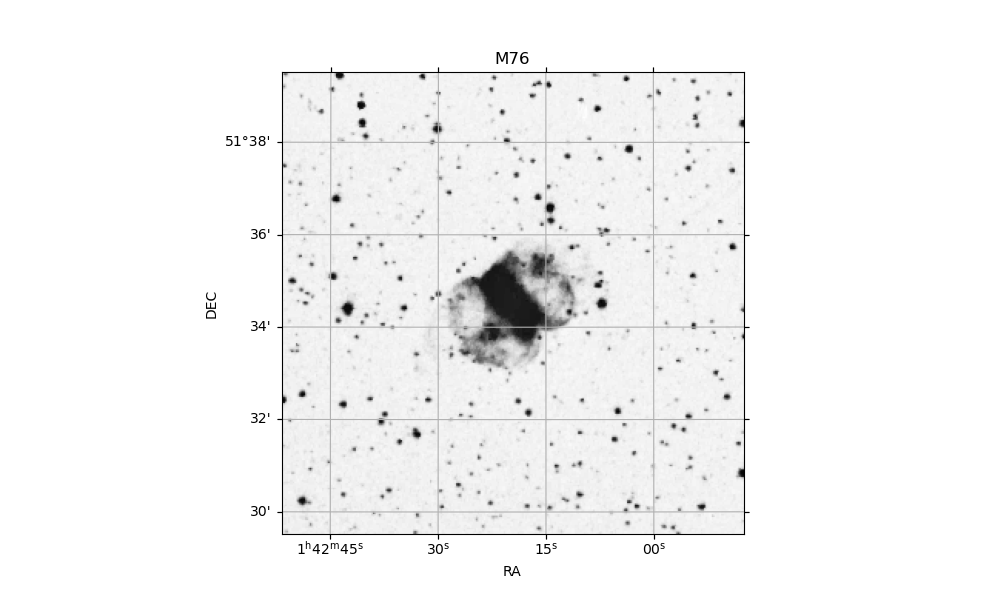

In [15]:
#Image de M76
plt.figure(figsize=(10,6))
M76 = FixedTarget.from_name('M76')
ax, hdu = plot_finder_image(M76)
plt.show()

<IPython.core.display.Javascript object>


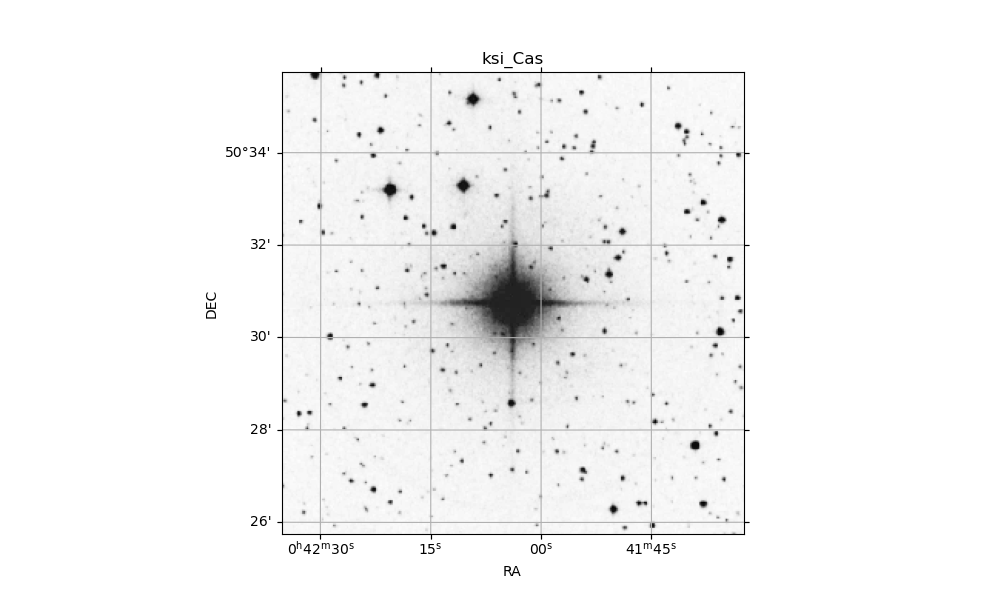

In [16]:
#Image de ksi_Cas
plt.figure(figsize=(10,6))
ksi_Cas = FixedTarget.from_name('ksi_Cas')
ax, hdu = plot_finder_image(ksi_Cas)
plt.show()

In [17]:
#Calcul du redshift

longitude = 5.712222 * u.deg
latitude = 43.931667 * u.deg
elevation = 650. * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)
observer = Observer(name='OHP',
                    location=location,
                    timezone=timezone('UTC'))

z_M76=[]
z_ksi_Cas=[]


time = Time(rvstd_s1d.header['date'])
z_ksi_Cas.append(ksi_Cas.coord.radial_velocity_correction(kind='barycentric', obstime=time, location=location).to(u.km/u.s))#/(3.e5 * u.km/u.s))
print("Le redshift associé à Ksi_Cas est : "+str(z_ksi_Cas))
print('\n')


time = Time(sci_s1d.header['date'])
z_M76.append(M76.coord.radial_velocity_correction(kind='barycentric', obstime=time, location=location).to(u.km/u.s))#/(3.e5 * u.km/u.s))
print("Le redshift associé à M76 est : "+str(z_M76))


Les redshifts associés aux Ksi_Cas sont : [<Quantity 12.49349142 km / s>]


Les redshifts associés aux M76 sont : [<Quantity 16.73586292 km / s>]


## Apply wavelength calibration to science and RV standard spectra + save to FITS

In [18]:
# Save science spectrum as a fits file
## primary HDU contains header from parent file
prihdu_sci_fw = pf.PrimaryHDU(header=sci_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
sci_fw_tab = QTable([lam1[::-1]*u.AA, sci_f_s1d.data[::-1]*u.electron, sig_sci_f_s1d.array[::-1]*u.electron], names=('wavelength', 'flux', 'uncertainty'))
sci_fw_hdu = pf.table_to_hdu(sci_fw_tab)
sci_hdul = pf.HDUList([prihdu_sci_fw, sci_fw_hdu])
bname, ext = os.path.splitext(fname_sci)
fname_sci_fw = bname.rstrip('_s1d') + '_fw_s1d' + ext
sci_hdul.writeto('reduced/'+fname_sci_fw, overwrite=True)
print(fname_sci_fw, 'saved')
## alternatively one can just save the QTable but original header info is lost
#sci_fw_tab.write('reduced/'+fname_sci_fw, overwrite=True)

# Save RV standard spectrum as a fits file
## primary HDU contains header from parent file
prihdu_rvstd_fw = pf.PrimaryHDU(header=rvstd_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
rvstd_fw_tab = QTable([lam1[::-1]*u.AA, rvstd_f_s1d.data[::-1]*u.electron, sig_rvstd_f_s1d.array[::-1]*u.electron], names=('wavelength', 'flux', 'uncertainty'))
rvstd_fw_hdu = pf.table_to_hdu(rvstd_fw_tab)
rvstd_hdul = pf.HDUList([prihdu_rvstd_fw, rvstd_fw_hdu])
bname, ext = os.path.splitext(fname_rvstd)
fname_rvstd_fw = bname.rstrip('_s1d') + '_fw_s1d' + ext
rvstd_hdul.writeto('reduced/'+fname_rvstd_fw, overwrite=True)
print(fname_rvstd_fw, 'saved')
## alternatively one can just save the QTable but original header info is lost
#sci_fw_tab.write('reduced/'+fname_rvstd_fw, overwrite=True)

Master_M76_fw_s1d.fit saved
Master_ksi_Ca_fw_s1d.fit saved


<IPython.core.display.Javascript object>


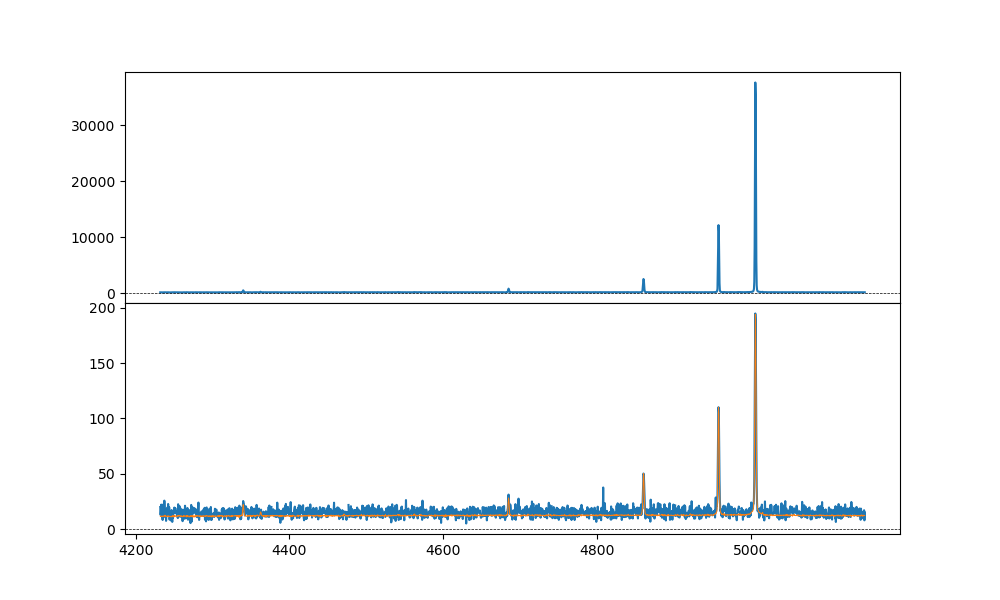

In [19]:
# Plot the spectrum and its uncertainty
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0)
# science spectrum
ax1.plot(sci_fw_tab['wavelength'], sci_fw_tab['flux'])
ax1.axhline(0., ls='--', c='k', lw=.5)
# associated uncertainty'
ax2.plot(sci_fw_tab['wavelength'], sci_fw_tab['uncertainty'])
ax2.plot(sci_fw_tab['wavelength'], np.sqrt(sci_fw_tab['flux']), lw=0.7)
ax2.axhline(0., ls='--', c='k', lw=.5)
#ax2.set_xlim(0,1.e3)
plt.show()

In [20]:
# First method to load only binary table data
spec1d = QTable.read('reduced/'+fname_sci_fw)
print(spec1d)

    wavelength            flux           uncertainty    
     Angstrom                                           
------------------ ------------------ ------------------
 5148.551181918272 153.87515313583387 15.266300218934736
  5148.10345025441 154.26569511389218   8.12030387136042
 5147.655718575308 160.49573081457424 17.235357953330848
 5147.207986880969 161.84873181835852 11.406922662580941
  5146.76025517139 149.63631562149206 16.193084848348647
5146.3125234465715 162.30594259792127  15.42785505605469
5145.8647917065155  139.5586749289569 15.387340867548541
  5145.41705995122 161.79782684810823 15.665321916569903
 5144.969328180686 149.67984384758307 14.376720124128031
 5144.521596394912  153.0560832287805  9.777835404652269
               ...                ...                ...
 4236.042419724964 144.94438332856544  22.51225078276525
 4235.594657004409  131.5435438023988 18.294333955308485
 4235.146894268615 138.97392168777148  8.456769997029058
 4234.699131517583 143.84126440

In [21]:
# Second method to retrieve metadata info as well
spec1d = pf.open('reduced/'+fname_sci_fw, ignore_missing_end=True)
print(spec1d.info())
print('\n')
print(spec1d[0].header)
print('\n')
print(spec1d[1].header)
print('\n')
print(type(spec1d[1]))

Filename: reduced/Master_M76_fw_s1d.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1                1 BinTableHDU     15   2048R x 3C   [D, D, D]   
None


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H HEAD    = 'DU940P_BV'          / Head model                                     ACQMODE = 'Single Scan'        / Acquisition mode                               READMODE= 'Image   '           / Readout mode                                   IMGRECT = '1, 2048, 512, 1'    / Image format       



XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   24 / length of dimension 1                          NAXIS2  =                 2048 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'wavelength'                                                          TFORM1  = 'D       '                                                            TUNIT1  = 'Angstrom'                                                            TTYPE2  = 'flux    '                                                            TFORM2  = 'D       '                  